# Off-the-shelf HuggingFace models for audio deepfake detection


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adrianastan/deepfake_pydata/blob/main/HF_audio_deepfake.ipynb)


## <font color="#e8710a">©Adriana STAN </font>

adrianac.stan@gmail.com | www.adrianastan.com

PyData Cluj Meetup - October, 29th 2024




## Setup

In [1]:
import torch
import librosa
import os, sys
from tqdm import tqdm
import numpy as np
import seaborn as sns
from IPython.display import Audio
from transformers import AutoFeatureExtractor, WavLMModel, Wav2Vec2Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

import matplotlib.pylab as plt
from sklearn.manifold import TSNE

## Dataset download

We will use ASVSpoof 2019 dataset with its train/dev/test partitions:  https://zenodo.org/records/6906306

In [ ]:
# !wget -O LA.zip https://zenodo.org/records/6906306/files/LA.zip?download=1

In [ ]:
# !unzip LA.zip

If you already have the data in your Drive, first connect to the Drive and the change the path to where your data is

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd "/content/drive/MyDrive/PRESENTATIONS/2024_PyData_Cluj/"

/content/drive/MyDrive/PRESENTATIONS/2024_PyData_Cluj


### Process the metadata



In [4]:
with open('data/ASVspoof2019.LA.cm.train.trn.txt') as fin:
  train_labels = {line.strip().split()[1]:1 if line.strip().split()[-1]=='spoof' else 0 for line in fin.readlines()}

In [5]:
with open('data/ASVspoof2019.LA.cm.eval.trl.txt') as fin:
  eval_labels = {line.strip().split()[1]:1 if line.strip().split()[-1]=='spoof' else 0 for line in fin.readlines()}

Listen to some audio samples

In [6]:
print(f"Label: {'spoof' if train_labels['LA_T_9950114']==1 else 'bonafide'}")
Audio('data/audio/LA_T_9950114.flac')

Label: spoof


In [7]:
print(f"Label: {'spoof' if train_labels['LA_T_9953580']==1 else 'bonafide'}")
Audio('data/audio/LA_T_9953580.flac')

Label: spoof


## Download and setup the HF models


Please make sure that you enable a GPU runtime

In [8]:
class HuggingFaceFeatureExtractor:
    def __init__(self, model_class, name):
        self.device = "cuda"
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(name)
        self.model = model_class.from_pretrained(name)
        self.model.eval()
        self.model.to(self.device)

    def __call__(self, audio, sr):
        inputs = self.feature_extractor(
            audio,
            sampling_rate=sr,
            return_tensors="pt",
            padding=True,
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(
                **inputs,
            )
        return outputs.last_hidden_state

In [9]:
FEATURE_EXTRACTORS = {
    "wav2vec2-base": lambda: HuggingFaceFeatureExtractor(
        Wav2Vec2Model, "facebook/wav2vec2-base"
    ),
    "wavlm-base": lambda: HuggingFaceFeatureExtractor(
        WavLMModel, "microsoft/wavlm-base"
    )
}

In [10]:
model_wav2vec2 = FEATURE_EXTRACTORS['wav2vec2-base']()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model_wavlm = FEATURE_EXTRACTORS['wavlm-base']()

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/wavlm-base were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the model checkpoint at microsoft/wavlm-base and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

## Feature extraction

### wav2vec2

In [15]:
indir = 'data/audio'

In [16]:
files = [k for k in sorted(os.listdir(indir))]
print ("Using %d files" %len(files))

wav2vec2_feats= np.zeros((len(files), 768))
labels = np.zeros(len(files))

for i, fi in enumerate(tqdm(files)):
    # read the audio and resample to 16kHz
    audio, sr = librosa.load(os.path.join(indir,fi), sr=16_000)
    # run the inference
    feat = model_wav2vec2(audio, sr)
    # average across time
    wav2vec2_feats[i] = np.mean(feat.squeeze().cpu().detach().numpy(), axis=0)
    labels[i] = train_labels[os.path.splitext(fi)[0]]

np.save('wav2vec2_features.npy', {'X': wav2vec2_feats, 'y':labels, 'files':files})

Using 36 files


100%|██████████| 36/36 [00:01<00:00, 33.59it/s]


### wavLM

In [17]:
files = [k for k in sorted(os.listdir(indir))]
print ("Using %d files" %len(files))
wavlm_feats= np.zeros((len(files), 768))

for i, fi in enumerate(tqdm(files)):
    # read the audio and resample to 16kHz
    audio, sr = librosa.load(os.path.join(indir,fi), sr=16_000)
    # run the inference
    feat = model_wavlm(audio, sr)
    # average across time
    wavlm_feats[i] = np.mean(feat.squeeze().cpu().detach().numpy(), axis=0)

np.save('wavlm_features.npy', {'X': wavlm_feats, 'y':labels, 'files':files})

Using 36 files


  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 36/36 [00:01<00:00, 18.48it/s]


## Setup the data and classifier



### wav2vec2 results

In [18]:
# data = np.load('wav2vec2_features.npy', allow_pickle=True).item()
# X = data['X']
# y = data['y']

I already have the features extracted with the 2 models, so I will just load them

In [19]:
data_train = np.load('data/asvspoof19-train-wav2vec2-base-all.h5.npz')
X_train = data_train['X']
y_train = data_train['y']

data_test = np.load('data/asvspoof19-eval-wav2vec2-base-all.h5.npz')
X_test = data_test['X']
y_test = data_test['y']

Look at the data

In [20]:
print(f"TRAIN set: Number of fake samples: {np.where(y_train==1)[0].shape[0]} | Number of real samples: {np.where(y_train==0)[0].shape[0]}")

TRAIN set: Number of fake samples: 22800 | Number of real samples: 2580


In [21]:
print(f"TEST set: Number of fake samples: {np.where(y_test==1)[0].shape[0]} | Number of real samples: {np.where(y_test==0)[0].shape[0]}")

TEST set: Number of fake samples: 63882 | Number of real samples: 7355


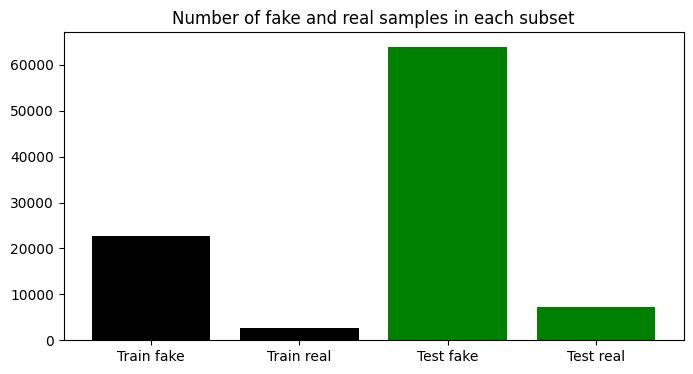

In [22]:
plt.figure(figsize=(8,4))
plt.bar([0,1], [np.where(y_train==1)[0].shape[0], np.where(y_train==0)[0].shape[0]], color='black')
plt.bar([2,3], [np.where(y_test==1)[0].shape[0], np.where(y_test==0)[0].shape[0]], color = 'green')
plt.title("Number of fake and real samples in each subset")
plt.xticks([0,1,2,3],['Train fake', 'Train real', 'Test fake', 'Test real']);

Let see some samples projected into 2D space

In [23]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20)
# take just a subset of samples
X_embb_train = tsne.fit_transform(X_train[::10])

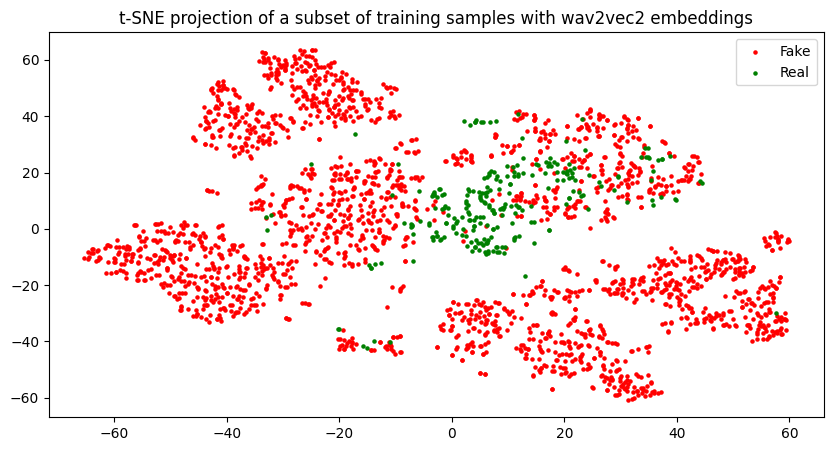

In [24]:
ytsne = y_train[::10] # take just a subset of samples
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.figure(figsize=(10,5))
plt.title("t-SNE projection of a subset of training samples with wav2vec2 embeddings")
plt.scatter(X_embb_train[fake_indices,0], X_embb_train[fake_indices,1], color='r', s=5)
plt.scatter(X_embb_train[real_indices,0], X_embb_train[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);

Same for the test set

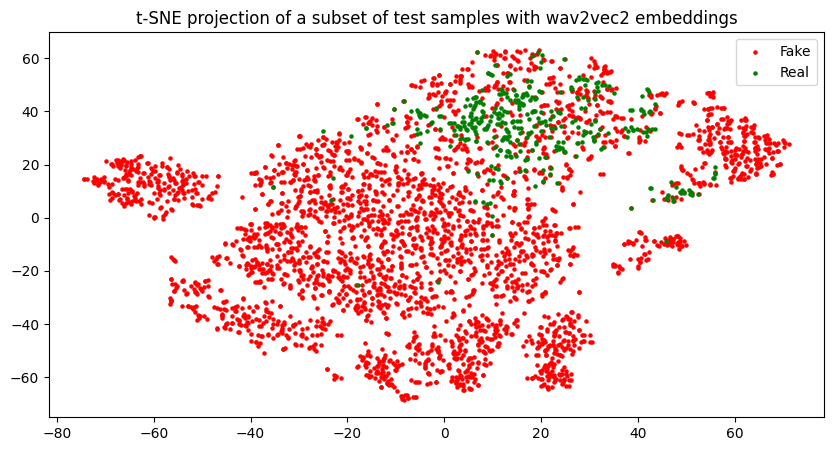

In [25]:
X_embb_test = tsne.fit_transform(X_test[::20])
ytsne = y_test[::20]
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.figure(figsize=(10,5))
plt.title("t-SNE projection of a subset of test samples with wav2vec2 embeddings")
plt.scatter(X_embb_test[fake_indices,0], X_embb_test[fake_indices,1], color='r', s=5)
plt.scatter(X_embb_test[real_indices,0], X_embb_test[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);

#### Fit the classifier

You can choose others as well...

In [26]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

Predict....

First on the training data

In [27]:
y_hat_train = clf.predict(X_train)

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      2580
         1.0       1.00      1.00      1.00     22800

    accuracy                           0.99     25380
   macro avg       0.99      0.98      0.98     25380
weighted avg       0.99      0.99      0.99     25380



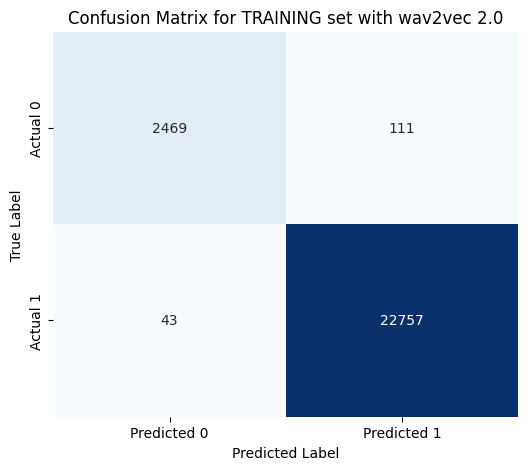

In [41]:
print(classification_report(y_train, y_hat_train))
cm = confusion_matrix(y_train, y_hat_train)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for TRAINING set with wav2vec 2.0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label");

And on the test data

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      7355
         1.0       0.98      0.98      0.98     63882

    accuracy                           0.96     71237
   macro avg       0.89      0.91      0.90     71237
weighted avg       0.96      0.96      0.96     71237



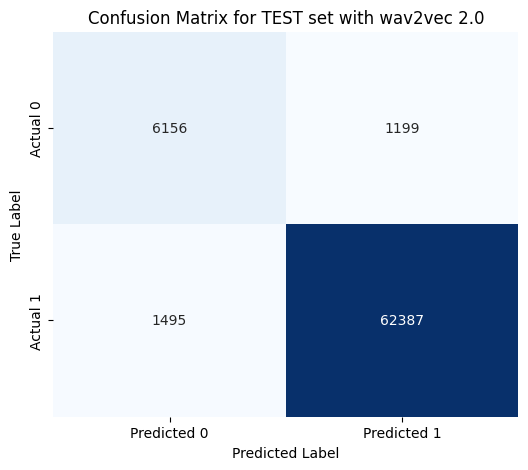

In [42]:
y_hat_test = clf.predict(X_test)
print(classification_report(y_test, y_hat_test))
cm = confusion_matrix(y_test, y_hat_test)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for TEST set with wav2vec 2.0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label");

We can also look at the normalised confusion matrix to get a better understandin

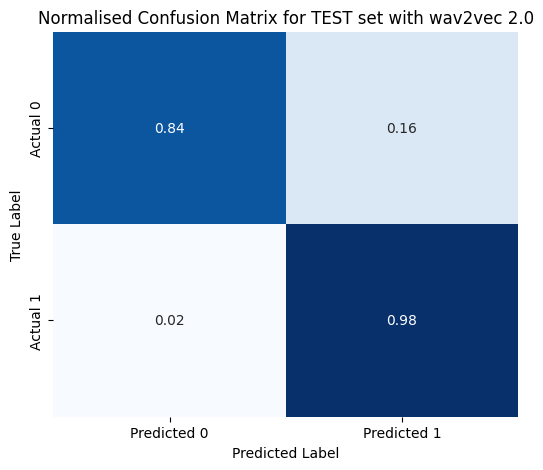

In [48]:
# NORMALISED CM
cm =confusion_matrix(y_test, y_hat_test, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Normalised Confusion Matrix for TEST set with wav2vec 2.0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label");

We can also compute the **Equal Error Rate** = the point where the False Acceptance Rate (FAR) equals the False Rejection Rate (FRR)

In [35]:
y_hat_train_proba=clf.predict_proba(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_hat_train_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("Training set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))

Training set EER:  1.24 | Threshold:  0.795


In [36]:
y_hat_test_proba=clf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("Test set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))

Test set EER:  5.28 | Threshold:  0.775


### wavLM results

In [37]:
# train data
data_train = np.load('data/asvspoof19-train-wavlm-base-all.h5.npz')
X_train = data_train['X']
y_train = data_train['y']

# test data
data_test = np.load('data/asvspoof19-eval-wavlm-base-all.h5.npz')
X_test = data_test['X']
y_test = data_test['y']

t-SNE for wavLM embeddings

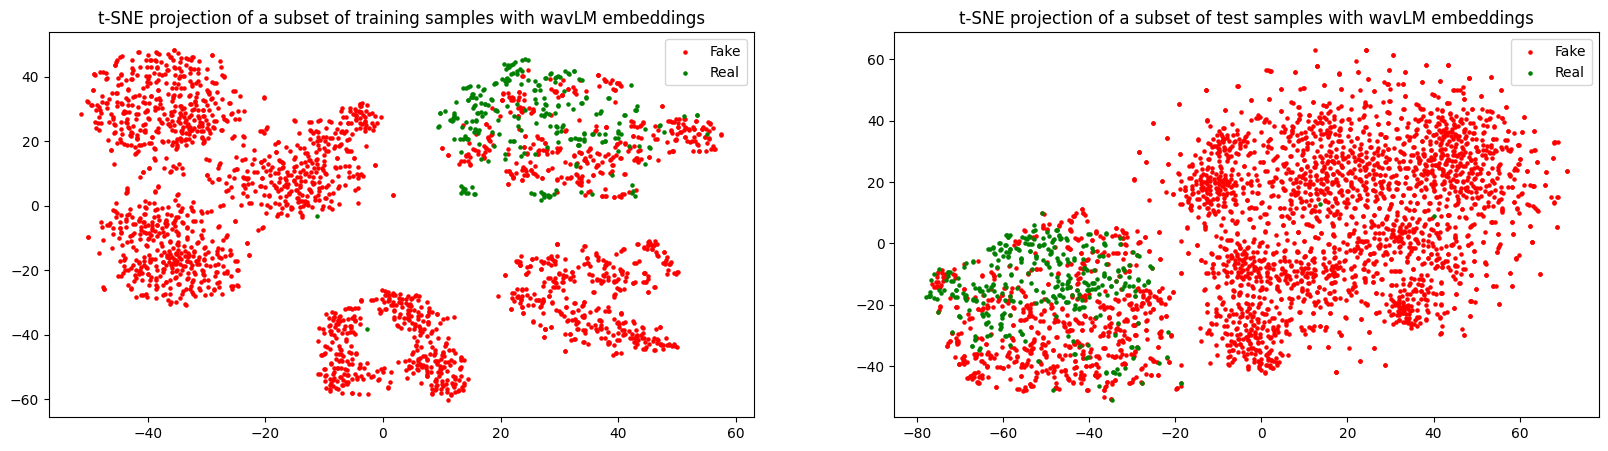

In [ ]:
X_embb = tsne.fit_transform(X_train[::10])

ytsne = y_train[::10]
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("t-SNE projection of a subset of training samples with wavLM embeddings")
plt.scatter(X_embb[fake_indices,0], X_embb[fake_indices,1], color='r', s=5)
plt.scatter(X_embb[real_indices,0], X_embb[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);


X_embb = tsne.fit_transform(X_test[::20])
ytsne = y_test[::20]
fake_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==1]
real_indices = [i for i in range(ytsne.shape[0]) if ytsne[i]==0]

plt.subplot(122)
plt.title("t-SNE projection of a subset of test samples with wavLM embeddings")
plt.scatter(X_embb[fake_indices,0], X_embb[fake_indices,1], color='r', s=5)
plt.scatter(X_embb[real_indices,0], X_embb[real_indices,1], color='g', s=5)
plt.legend(["Fake", 'Real']);

#### Fit the classifier

In [38]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

Training set results
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      2580
         1.0       1.00      1.00      1.00     22800

    accuracy                           0.99     25380
   macro avg       0.99      0.98      0.98     25380
weighted avg       0.99      0.99      0.99     25380


Training set EER:  1.05 | Threshold:  0.781


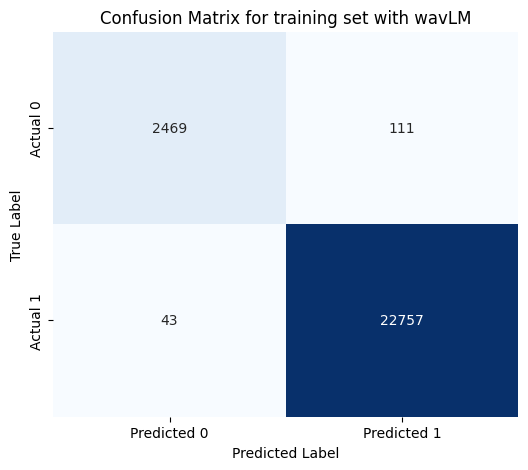

In [39]:
## Predict on train
print("Training set results")
y_hat_train = clf.predict(X_train)
print(classification_report(y_train, y_hat_train))
cm = confusion_matrix(y_train, y_hat_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for TRAINING set with wavLM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## EER
y_hat_train_proba=clf.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_hat_train_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("\nTraining set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))


Test set results
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      7355
         1.0       0.98      0.98      0.98     63882

    accuracy                           0.96     71237
   macro avg       0.89      0.91      0.90     71237
weighted avg       0.96      0.96      0.96     71237


Test set EER:  5.66 | Threshold:  0.843


Text(45.722222222222214, 0.5, 'True Label')

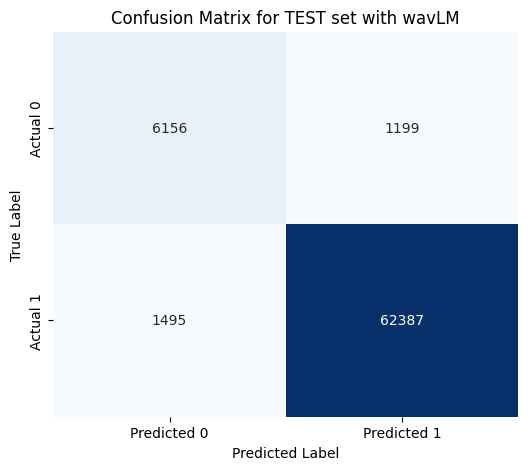

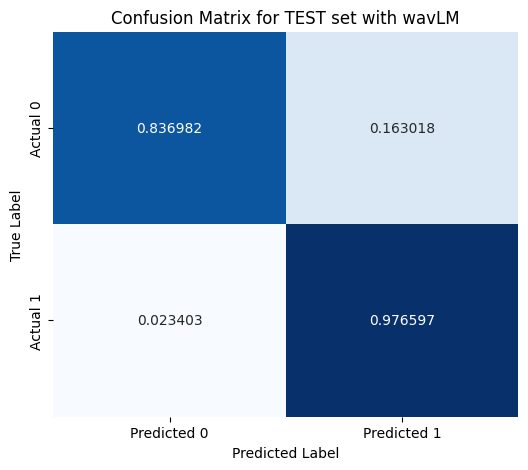

In [45]:
## Predict on test
print("Test set results")
y_hat_test = clf.predict(X_test)
print(classification_report(y_test, y_hat_test))
cm =confusion_matrix(y_test, y_hat_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Target 0', 'Target 1'])
plt.title("Confusion Matrix for TEST set with wavLM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## EER
y_hat_test_proba=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba[:,1], pos_label=1)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print ("\nTest set EER: ", np.round(eer*100,2), "| Threshold: ", np.round(thresh,3))

## Finally run the model on your sample

In [ ]:
# FILE_PATH = 'data/T_0000000010.flac' # fake
#FILE_PATH = 'data/T_0000000011.flac' #real
FILE_PATH = 'data/T_0000000019.flac' #fake

audio, sr = librosa.load(FILE_PATH, sr=16_000)
embedding = model_wav2vec2(audio, sr)
feat = np.mean(embedding.squeeze().cpu().detach().numpy(), axis=0)

y_hat = clf.predict(feat.reshape(1, -1))
y_hat_proba = clf.predict_proba(feat.reshape(1, -1))
print(f"Your sample is {'FAKE' if y_hat==1 else 'REAL'} with a probability of {(y_hat_proba[0][1] if y_hat==1 else y_hat_proba[0][0]):.2f}")

Your sample is FAKE with a probability of 0.96


In [ ]:
Audio('data/T_0000000019.flac')

## What next?



*   generalisation (OOD)
*   new systems = continual learning
*   model attribution
*   ...


